In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import datetime
import copy
import time
import wandb
import pickle as pkl
import sys
sys.path.append('../../')
from data.processing import get_data
import models
from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.fit import plot_histogram, plot_all_histograms, plot_mean_variance, plot_scatter, plot_kl_divergence, plot_heatmap_distribution_sigmas, plot_all_params, plot_all_losses, plot_all_buckets, plot_cv_in_params, plot_recovery_loss, plot_confidence_interval
import yaml
from data.dataloader import SimulatedDataLoader

In [20]:
simulated_config_filename = 'seirhd_fixed.yaml'
with open(os.path.join("../../configs/simulated_data/", simulated_config_filename)) as configfile:
    simulated_config = yaml.load(configfile, Loader=yaml.SafeLoader)    
actual_params = simulated_config['params']

In [4]:
predictions_dict = {}

In [6]:
config_filename = 'default.yaml'
config = read_config(config_filename)

Performing m1 fit ..
parameters used to generate data: {'lockdown_R0': 0.8, 'T_inc': 5.1, 'T_inf': 3.6, 'T_recov': 21.5, 'T_recov_fatal': 25.5, 'P_fatal': 0.08, 'E_hosp_ratio': 0.34, 'I_hosp_ratio': 0.94}
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 18                  | 19                  | 20                  | 21                  | 22                  |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| total       | 170289.0            | 172089.0            | 173897.0            | 175650.0            | 177360.0            |
| recovered   | 121521.0            | 123108.0            | 124724.0            | 126395.0            | 128135.0            |
| deceased    | 9503.0              | 9631.0              | 9749.0              | 9881.0              | 10038.0           

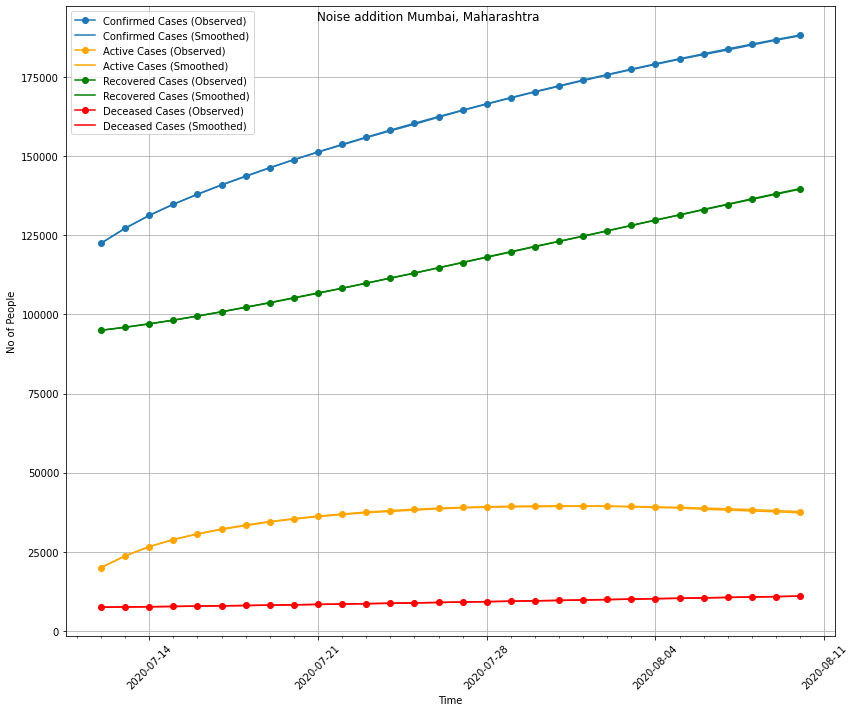

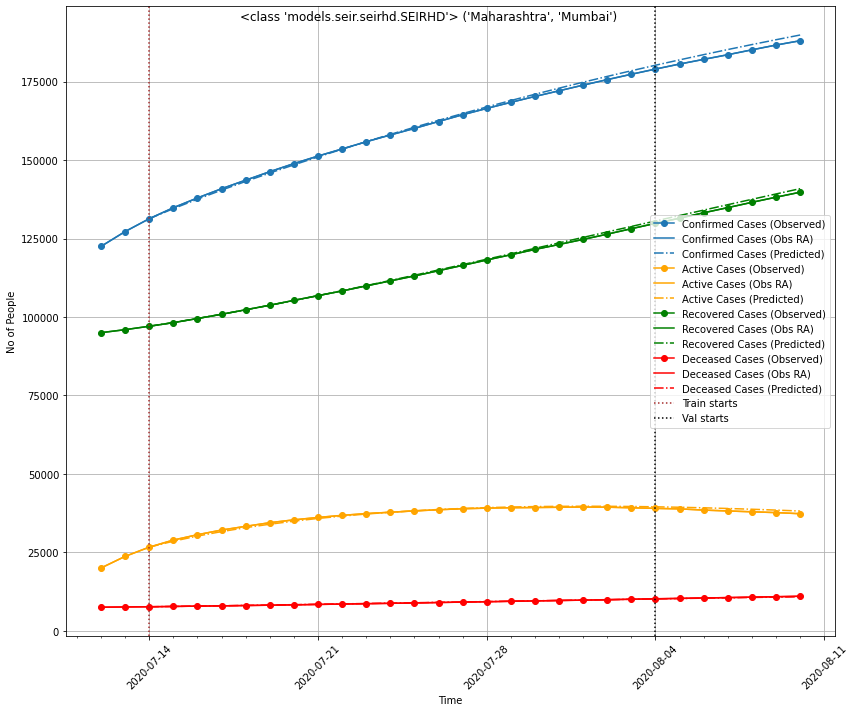

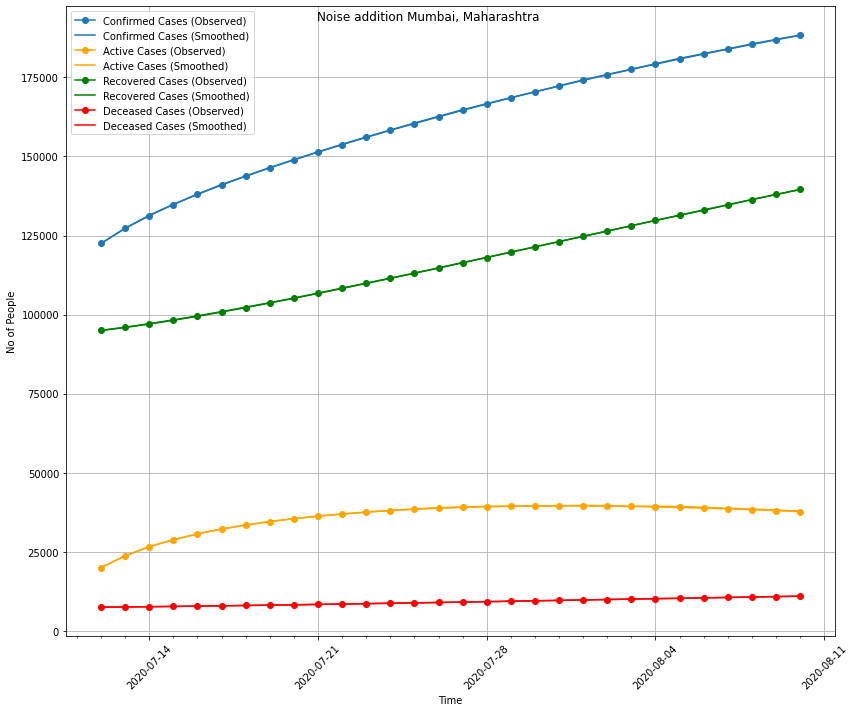

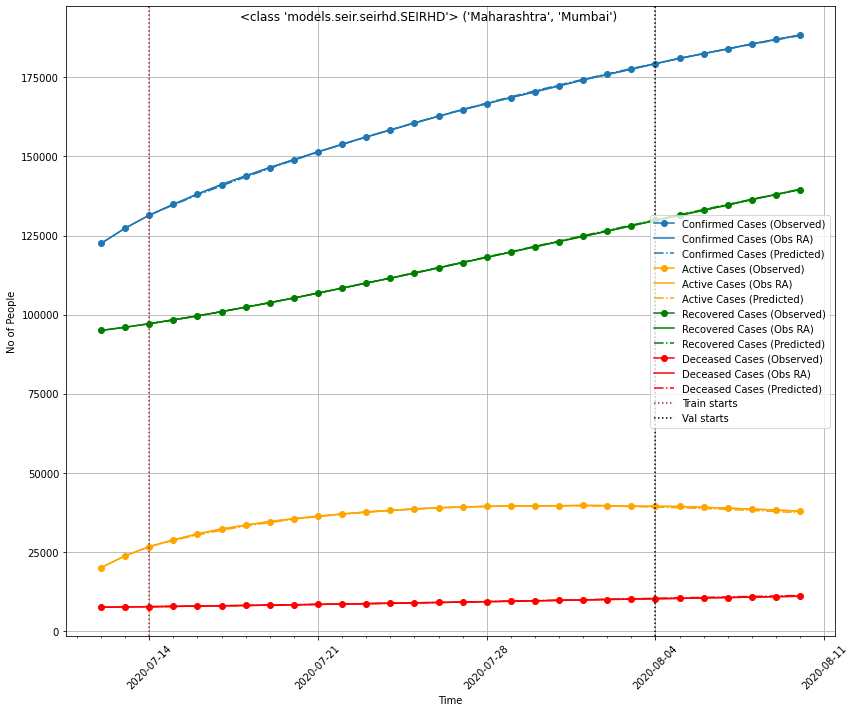

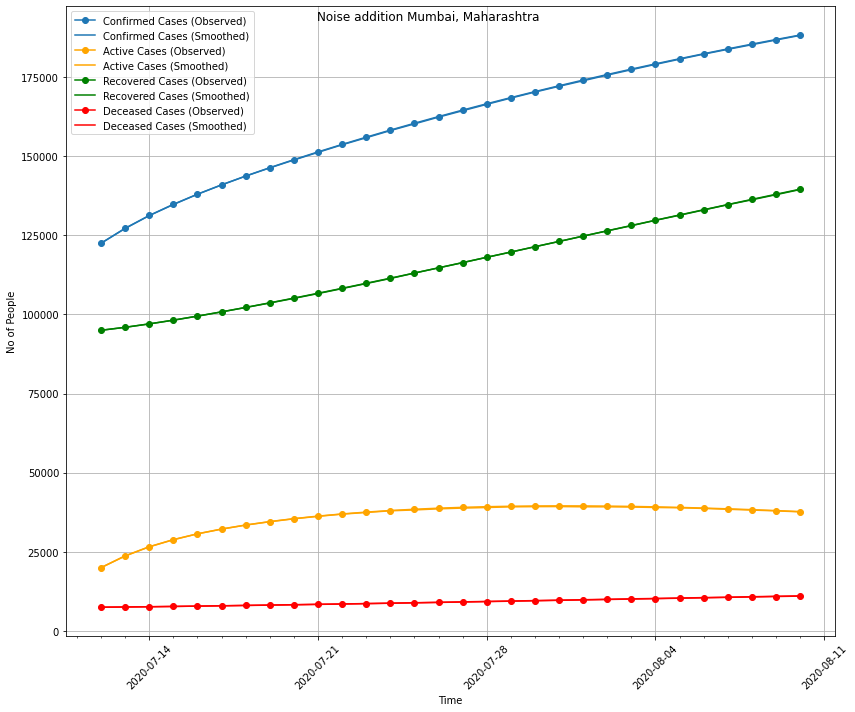

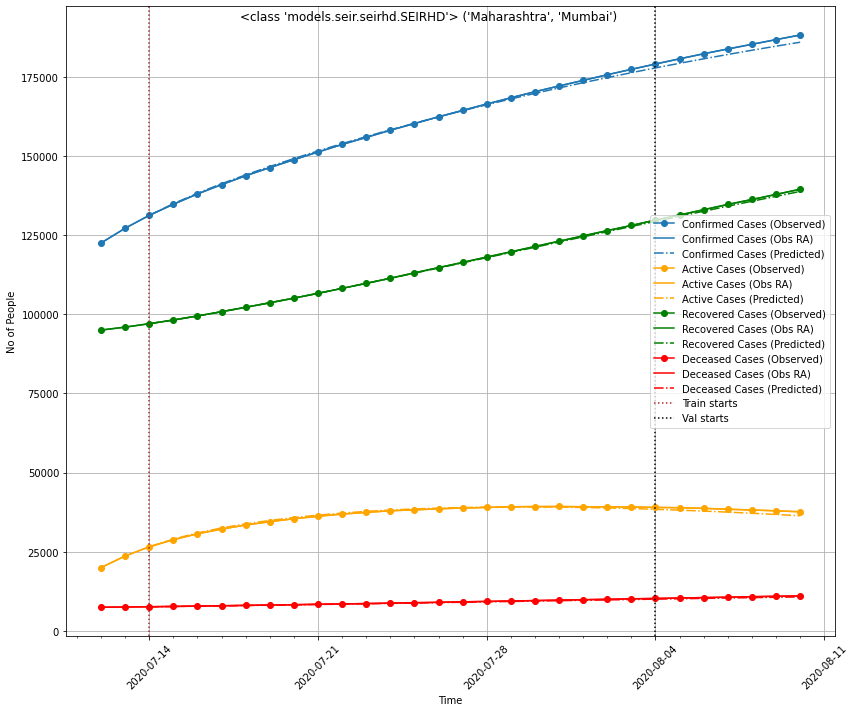

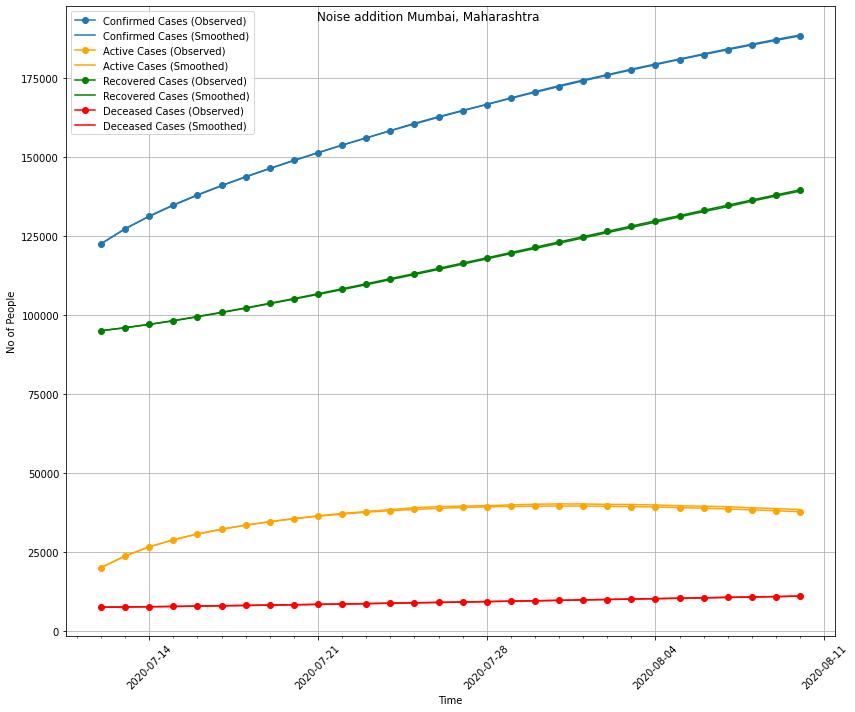

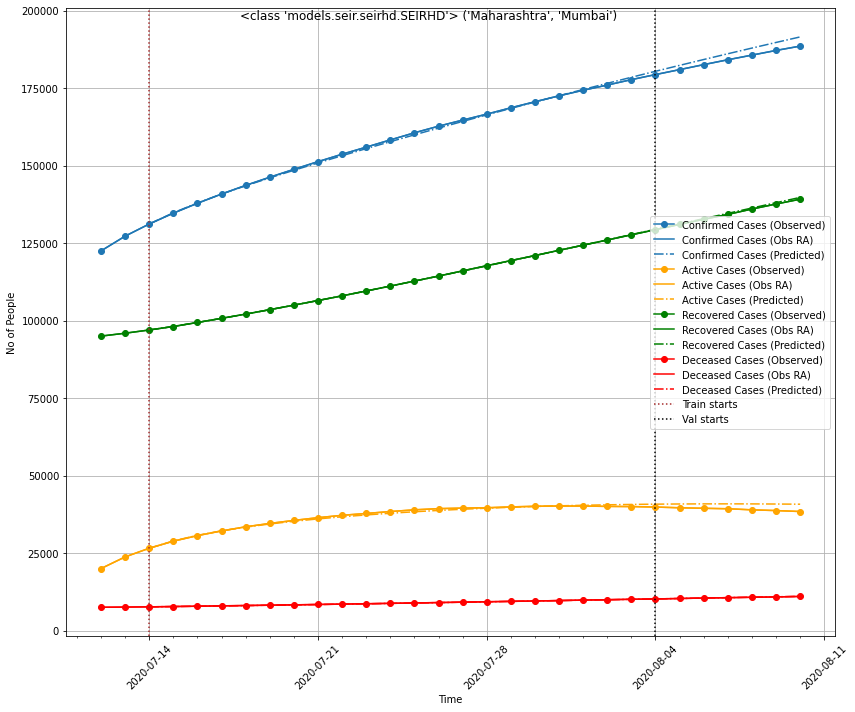

In [52]:
n = 2
m = 2
scenario_dict = {}
for i in range(1,n+1):
    best_fit_params = []
    for j in range(1,m+1):
        predictions_dict['m' + str(i)] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 
        best_fit_params.append(predictions_dict['m' + str(j)]['best_params'])
    scenario_dict['s' + str(i)] = best_fit_params

In [53]:
scenario_dict

{'s1': [{'E_hosp_ratio': 0.366282624354094,
   'I_hosp_ratio': 0.43273353721816676,
   'P_fatal': 0.05626417145811137,
   'T_inc': 4.013974295274794,
   'T_inf': 3.4728478390792445,
   'T_recov': 21.688674718165796,
   'T_recov_fatal': 14.95763166769319,
   'lockdown_R0': 0.831844173480909},
  {'E_hosp_ratio': 0.4654698852976648,
   'I_hosp_ratio': 0.46717106584349744,
   'P_fatal': 0.07100085517027976,
   'T_inc': 4.12560215398743,
   'T_inf': 3.9442704858601445,
   'T_recov': 22.077558573319163,
   'T_recov_fatal': 20.196334420821895,
   'lockdown_R0': 0.7092173240730947}],
 's2': [{'E_hosp_ratio': 0.41759517582957584,
   'I_hosp_ratio': 0.5080827916020768,
   'P_fatal': 0.09991378875863721,
   'T_inc': 4.599584585672927,
   'T_inf': 3.9993130366199896,
   'T_recov': 20.768910124103073,
   'T_recov_fatal': 32.614063959605375,
   'lockdown_R0': 0.768291250612687},
  {'E_hosp_ratio': 0.22109256117719484,
   'I_hosp_ratio': 0.5676445120668254,
   'P_fatal': 0.07550011040930116,
   'T_in

{}

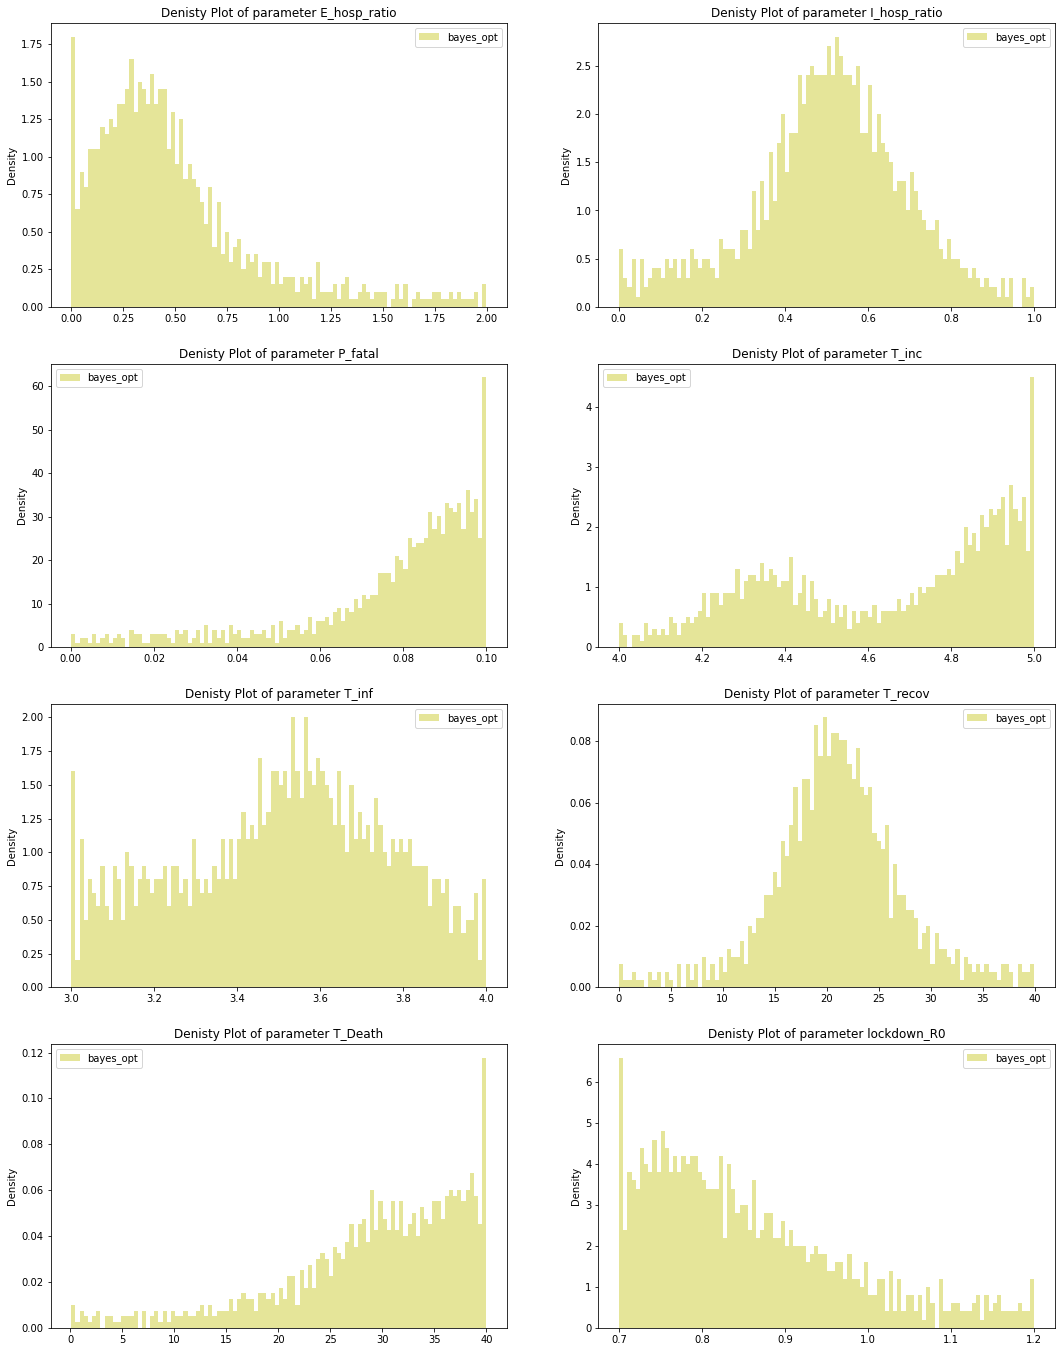

In [9]:
fig, axs = plt.subplots(nrows=8//2, ncols=2, 
                            figsize=(18, 6*8//2))
plot_histogram(predictions_dict['m1'], fig, axs, weighting='exp', beta=1, plot_lines=False, weighted=True, 
                   savefig=False, filename=None, label=None)

In [55]:
predictions_dict['m1'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'smoothing_description', 'df_district_unsmoothed', 'run_params'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
{'N': 10000000.0, 'lockdown_R0': 0.8, 'T_inc': 5.1, 'T_inf': 3.6, 'T_recov': 21.5, 'T_recov_fatal': 25.5, 'P_fatal': 0.08, 'E_hosp_ratio': 0.34, 'I_hosp_ratio': 0.94}
E_hosp_ratio [0.6301468223974629, 0.6301468223974629] 0.4158762548258794
I_hosp_r

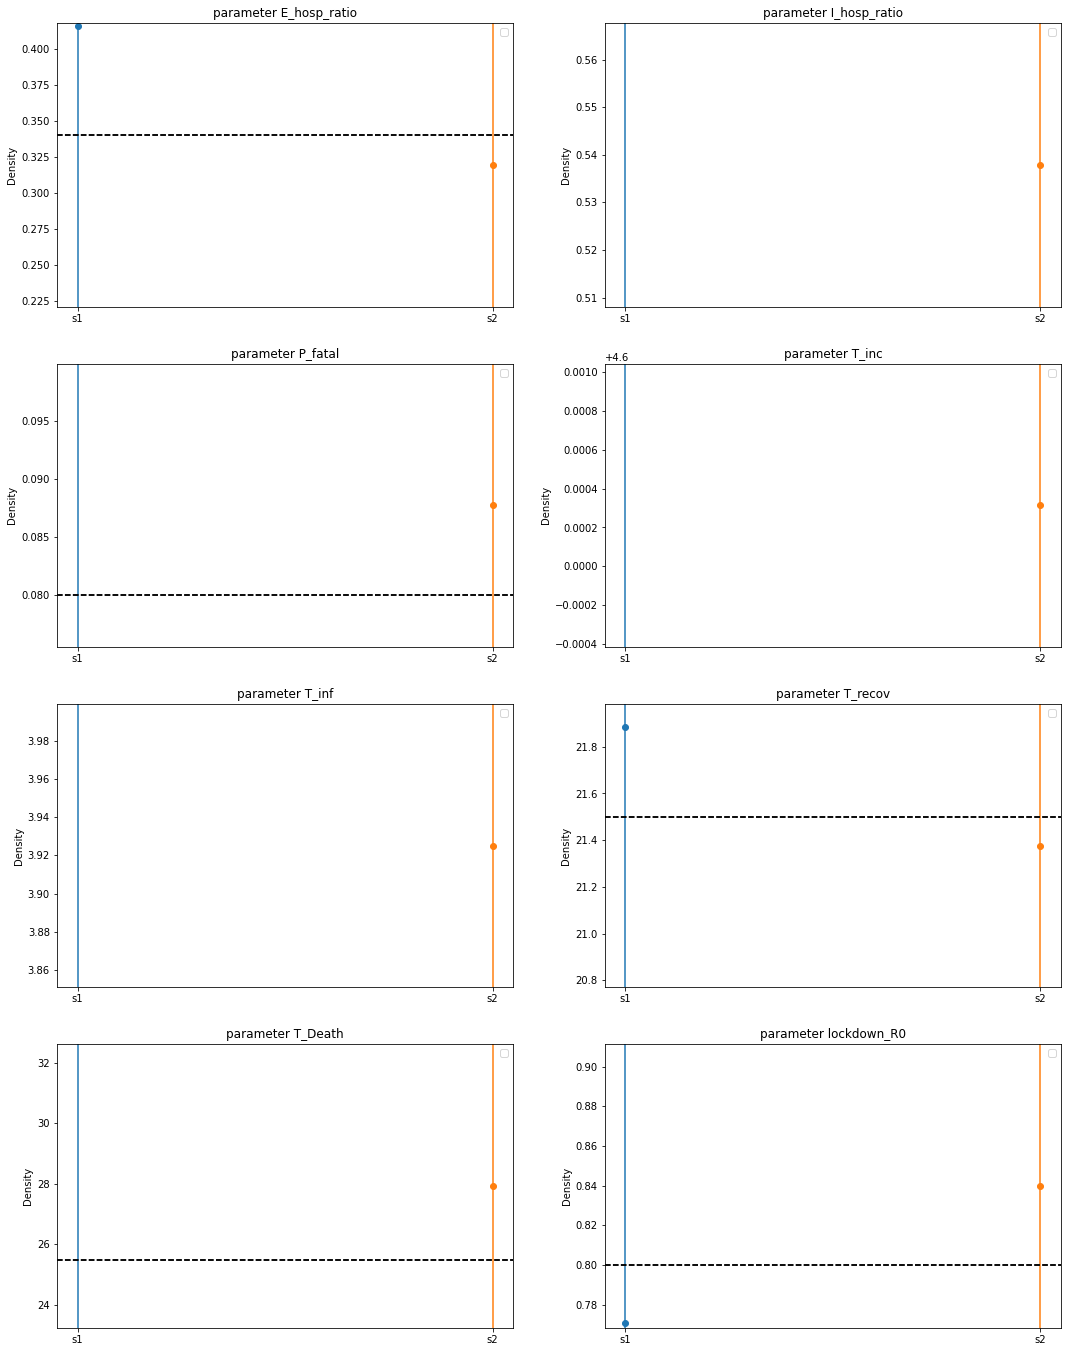

In [56]:
fig, axs = plt.subplots(nrows=8//2, ncols=2, 
                            figsize=(18, 6*8//2))
plot_confidence_interval(scenario_dict, fig, axs, actual_params=actual_params, range=config['fitting']['variable_param_ranges'])